In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils import data
from torch.optim import Adam

from torchvision import transforms
from torchvision import datasets

import numpy as np

from matplotlib import pyplot as plt
from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm

In [2]:
from rg_dataset import LRG, UNLRG_C

In [3]:
data_set = UNLRG_C(use_kittler=True, twice=True)
data_loader = data.DataLoader(data_set, batch_size=64, shuffle=False)
sample = iter(data_loader).next()

LRG:	1442/1442


In [4]:
len(sample)

3

In [37]:
class VAE(nn.Module):
    def __init__(self, lt_dim=4):
        super(VAE, self).__init__()
        self.k = [1, 16, 32, 128, 512, 1024]
        encoder_layers = []
        decoder_layers = []
        
        for i in range(len(self.k) - 1):
            layer = nn.Conv2d(self.k[i], self.k[i+1], 3, 2, 1, 1)
            encoder_layers.append(layer)
            encoder_layers.append(nn.ReLU())
        
        for i in range(len(self.k) - 1, 0, -1):
            layer = nn.ConvTranspose2d(self.k[i], self.k[i-1], 3, 2, 1, 1)
            decoder_layers.append(layer)
            decoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers[:-1])
        
        self.fc_mu = nn.Linear(self.k[-1]*2*2, lt_dim)
        self.fc_ep = nn.Linear(self.k[-1]*2*2, lt_dim)
        
        self.fc_dc = nn.Linear(lt_dim, self.k[-1]*2*2)
    def encode(self, x):
        encoded = self.encoder(x).view(-1, self.k[-1]*2*2)
        return self.fc_mu(encoded), self.fc_ep(encoded)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, x):
        x = F.relu(self.fc_dc(x)).view(-1, self.k[-1], 2, 2)
        return torch.sigmoid(self.decoder(x))
    
    def forward(self, x):
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        d = self.decode(z)
        return d, mu, var

In [38]:
class VAE_loss:
    def __init__(self):
        self.recon_ls = nn.BCELoss(reduction='sum')
    def update(self):
        pass
    def __call__(self, res, img):
        batch_sz = len(img)
        x, mu, logvar = res
        recon = self.recon_ls(x, img).div(batch_sz) #res -> x, mu, var
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()).div(batch_sz)
        return 0, recon, kld

class Beta_vae_loss:
    def __init__(self, gamma, max_capacity, epochs):
        self.gamma = gamma
#         self.recon_ls = nn.MSELoss(reduction='sum')
        self.recon_ls = nn.BCELoss(reduction='sum')
        self.capacity = 0
        self.delta = max_capacity / float(epochs)
        self.max_capacity = max_capacity
    def update(self):
        self.capacity = min(self.max_capacity, self.capacity + self.delta)
        return self.capacity
    def __call__(self, res, img):
        batch_sz = len(img)
#         print(res.shape)
        x, mu, logvar = res
        recon = self.recon_ls(x, img).div(batch_sz) #res -> x, mu, var
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()).div(batch_sz)
        return self.capacity, recon, self.gamma * (kld - self.capacity).abs()

In [39]:
def train_step(model, device, data_loader, optim, epoch, log_interval=5):
    model.train()
    s = ''
    b_count = 0
    for batch_idx, (data, data_dup, target) in enumerate(data_loader):
        b_count += len(data)
        data     = data.to(device)
        data_dup = data_dup.to(device)
        target = Variable(target, requires_grad=False).to(device)
        #Forward Pass
        optimizer.zero_grad()
        output   = model(data)

        # BCE Loss
        c, r_loss , g_loss = beta_vae_loss(output, data)
        loss = r_loss + g_loss
        
        #Backpropagation
        loss.backward()
        optimizer.step()
        s = 'Train Epoch: {:3d} [{:6d}/{:6d} ({:3.0f}%)    Loss: {:5.4f}    R_Loss: {:5.4f}    Capacity: {:3.4f}'
        s = s.format(epoch, b_count, len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item(), sim.item(), c)
        if batch_idx % log_interval == 0:
            sys.stdout.write('{}\r'.format(s))
            sys.stdout.flush()
    return s

In [40]:
device = 'cuda'

vae = VAE().to(device)
optimizer = Adam(vae.parameters(), lr=0.001)
epochs = 50

In [ ]:
beta_vae_loss = Beta_vae_loss(gamma=8, max_capacity=10, epochs=epochs)
# beta_vae_loss = VAE_loss() 
for epoch in range(1, epochs+1):
    start = time.time()
    s = train_step(vae, 'cuda' ,data_loader, optimizer, epoch)
    beta_vae_loss.update()
    t = time.time() - start
    sys.stdout.write('{0}    Time {1:3.2f}s\n'.format(s, t))

Train Epoch:   1 [ 14420/ 14420 (100%)    Loss: 671.1495    R_Loss: 0.0297    Capacity: 0.0000    Time 36.98s
Train Epoch:   2 [ 14420/ 14420 (100%)    Loss: 643.9903    R_Loss: 0.0358    Capacity: 0.2000    Time 36.05s
Train Epoch:   3 [ 14420/ 14420 (100%)    Loss: 635.1665    R_Loss: 0.0686    Capacity: 0.4000    Time 36.27s
Train Epoch:   4 [ 14420/ 14420 (100%)    Loss: 630.8682    R_Loss: 0.0524    Capacity: 0.6000    Time 36.24s
Train Epoch:   5 [ 14420/ 14420 (100%)    Loss: 607.3203    R_Loss: 0.0592    Capacity: 0.8000    Time 35.73s
Train Epoch:   6 [ 14420/ 14420 (100%)    Loss: 611.9871    R_Loss: 0.0938    Capacity: 1.0000    Time 35.78s
Train Epoch:   7 [ 14420/ 14420 (100%)    Loss: 609.9076    R_Loss: 0.2053    Capacity: 1.2000    Time 36.48s
Train Epoch:   8 [ 14420/ 14420 (100%)    Loss: 601.5172    R_Loss: 0.2156    Capacity: 1.4000    Time 36.64s
Train Epoch:   9 [ 14420/ 14420 (100%)    Loss: 592.0895    R_Loss: 0.7598    Capacity: 1.6000    Time 36.83s
Train Epoc

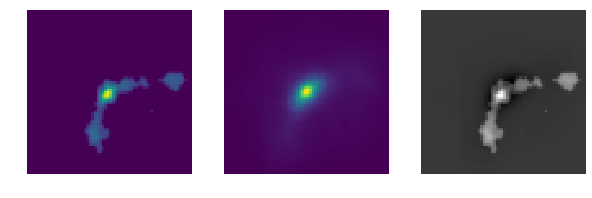

In [36]:
a = 1#6
s, l = sample[0][a:a+1], sample[1][a:a+1]
with torch.no_grad():
    e = vae.encode(s.to(device))[0]
    d = vae.decode(e)
f, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(s[0][0])
ax[1].imshow(d.cpu()[0][0])
ax[2].imshow(s[0][0] - d.cpu()[0][0], cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

# print(torch.sigmoid(e), l)
# sample

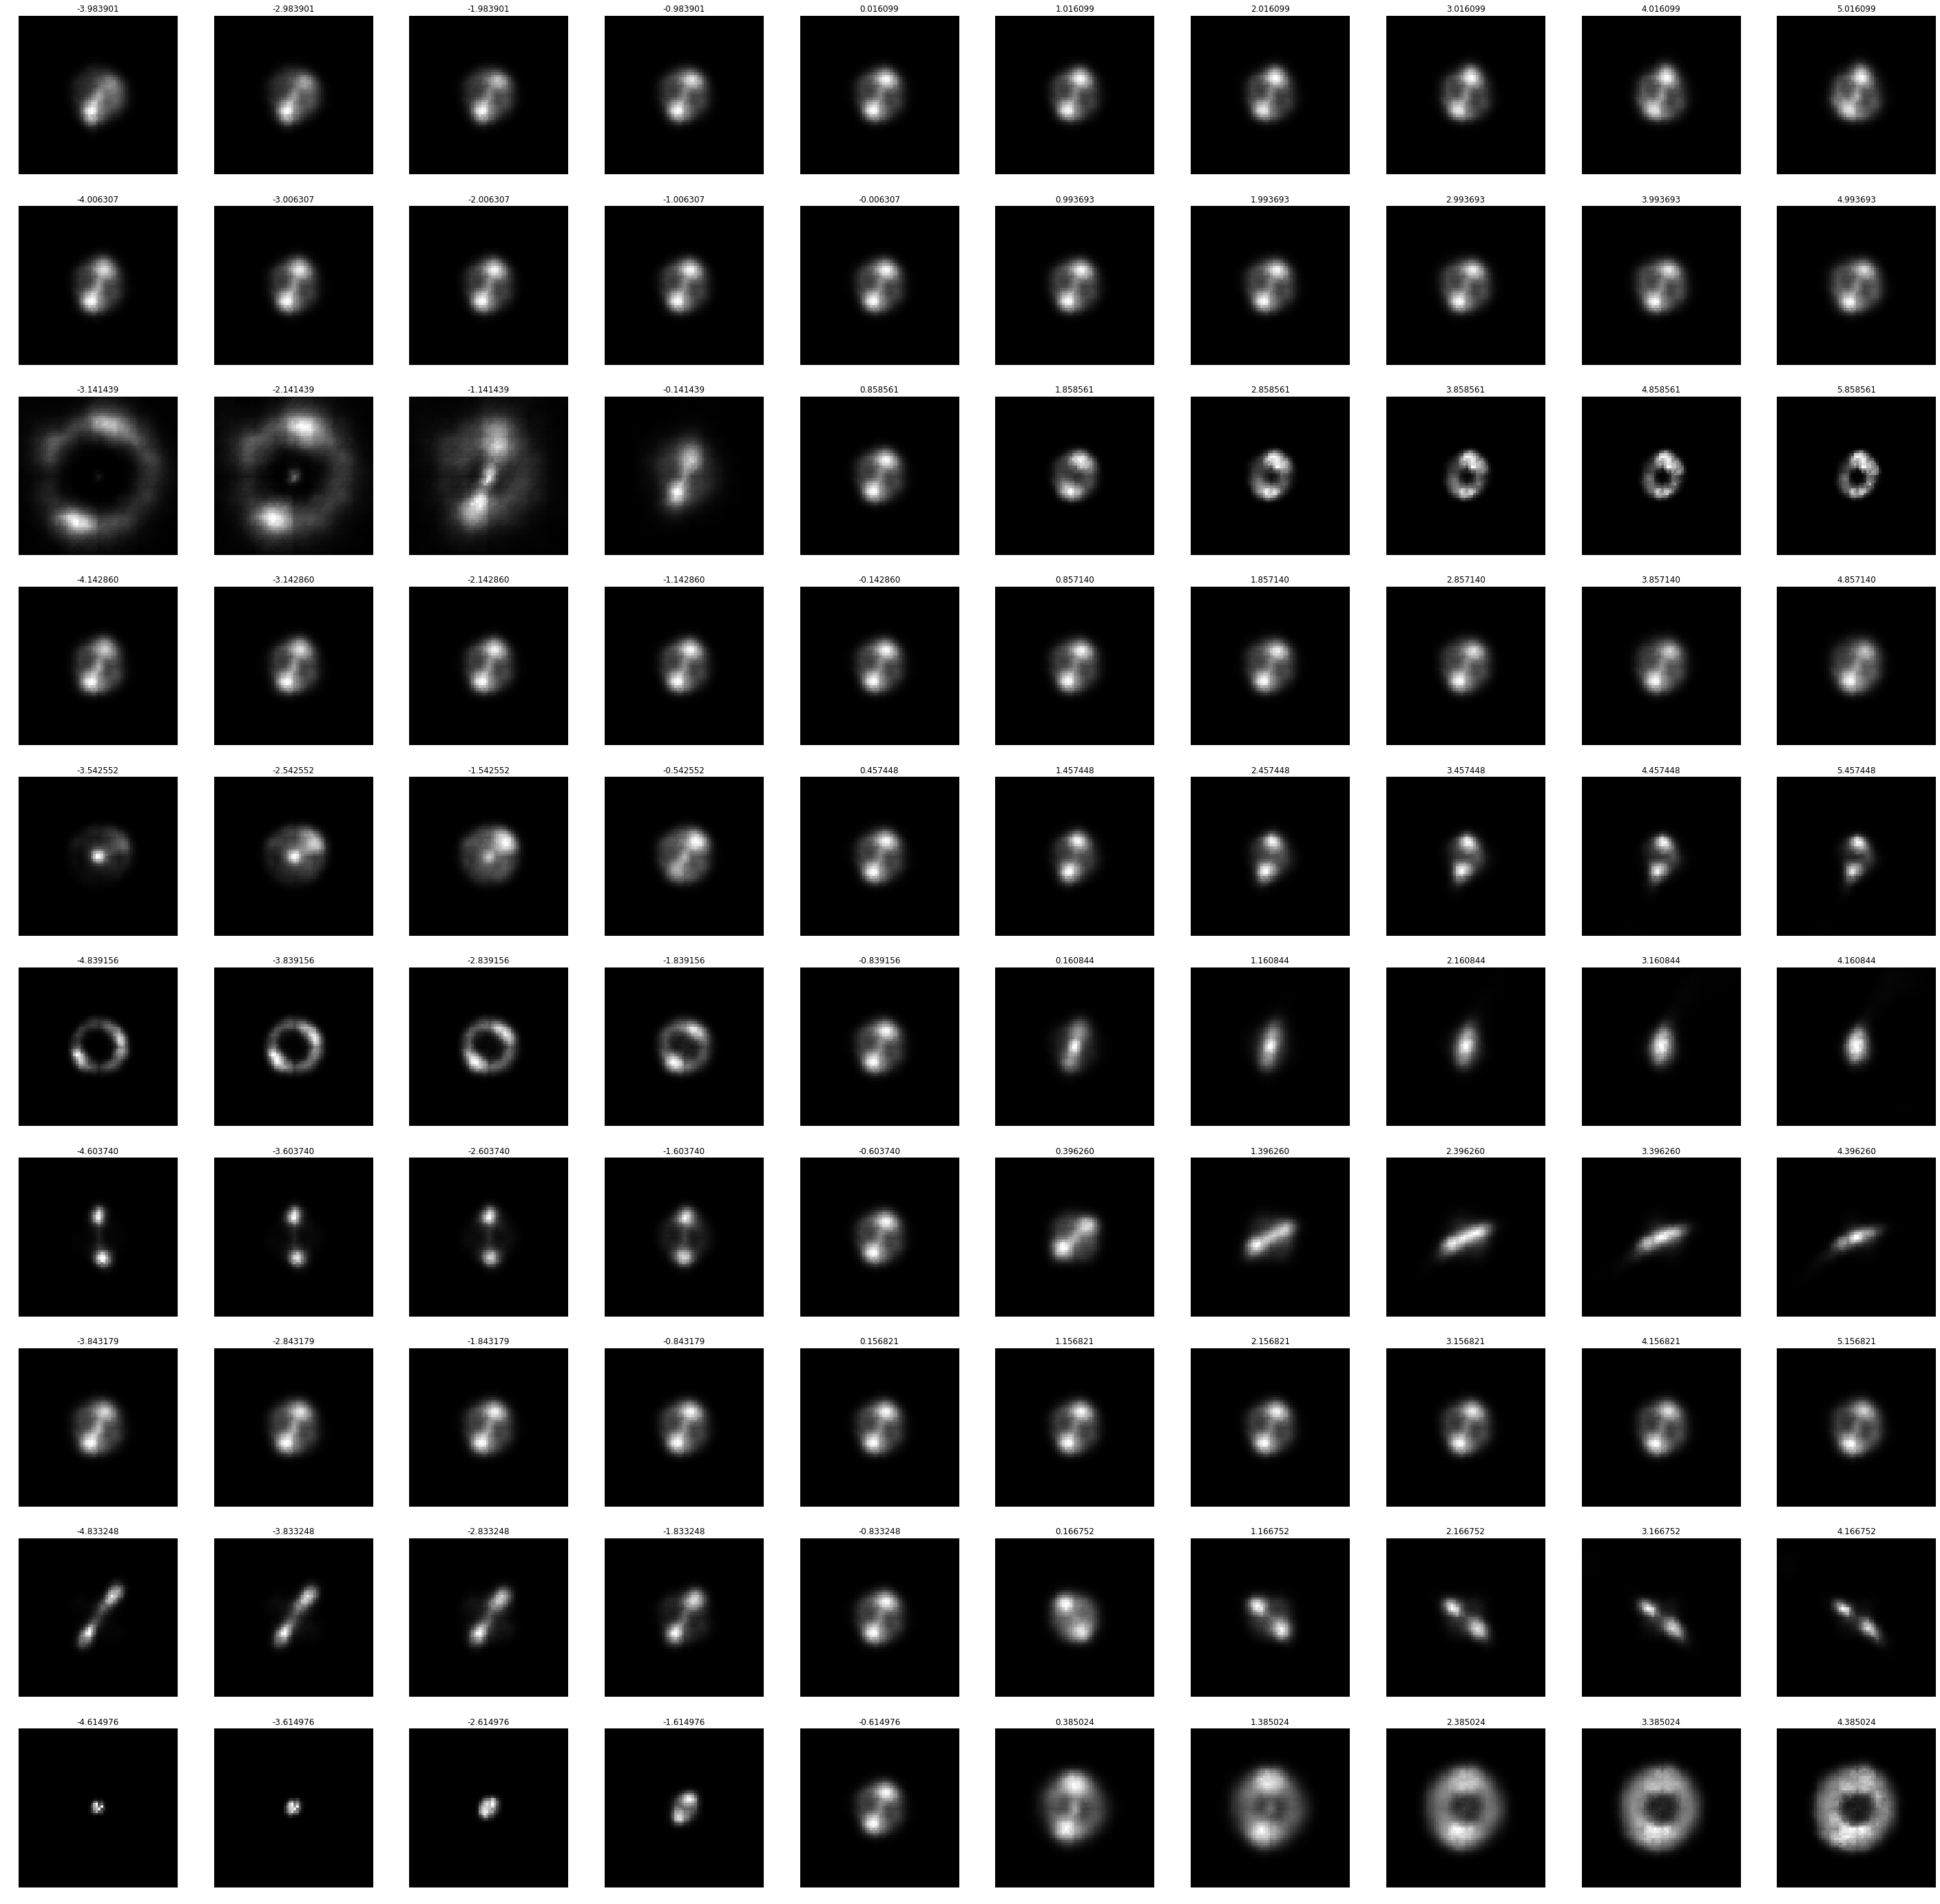

In [29]:
r = 10
nimg = r * 10
k=4
f, ax = plt.subplots(int(nimg/r), r, figsize=(r * 5, nimg * 5 / r))
for i in range(int(nimg/r)):
    for j in range(r):
        with torch.no_grad():
            e = vae.encode(s.to(device))[0]
            v = e[0][i]
            nv = -1*k + v + k*j/4
            e[0][i] = nv
            d = vae.decode(e).cpu()[0][0]
        ax[i][j].imshow(d, cmap='gray')
        ax[i][j].axis('off')
        ax[i][j].set_title('{:2f}'.format(nv))

In [ ]:
sample = iter(data_loader).next()
r = 10
nimg = r * 10
f, ax = plt.subplots(int(nimg/r), r, figsize=(r * 5, nimg * 5 / r))
for i in range(int(nimg/r)):
    for j in range(r):
        ax[i][j].imshow(sample[0][i*r+j][0], cmap='gray')
        ax[i][j].axis('off')
        ax[i][j].set_title('{:2f}'.format(nv))

In [ ]:
torch.save(vae, 'b_vae_rot_model')